In [1]:
import numpy as np
import scipy 
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
import scipy.optimize as optim
# import pysal
from tqdm import tqdm
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.axisbelow'] = True
#matplotlib.rcParams.update({'figure.autolayout': True})
matplotlib.rcParams['figure.figsize'] = [10, 7]

In [2]:
def make_matrix(rows, cols):
    n = rows*cols
    M = np.zeros((n,n))
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            # Two inner diagonals
            if c > 0: M[i-1,i] = M[i,i-1] = 1
            # Two outer diagonals
            if r > 0: M[i-cols,i] = M[i,i-cols] = 1
                
    return M

In [3]:
def euler_char(A,dim1,dim2,thresh):
    Betti1 = []
    edge = []
    vert = []
    com = []
    As = []
    Ms = []
    for t in tqdm(thresh):
        
        M = make_matrix(dim1,dim2)
        
        #Binary Image
        binary = (A <= t)*1
        #Adjust Adjaceny Matrix
        count = 0
        for i in range(np.shape(A)[1]):
            for j in range(np.shape(A)[0]):
                if binary[j,i] == 0:
                    M[count,:] = 0
                    M[:,count] = 0
                count += 1
                
        #Number Edges
        Edges = np.sum(M)/2
        
        #Number Vertices
        Vertices = np.sum(binary)
        
        removed_Vertices = np.shape(M)[0] - Vertices
        
        #Number Connected Components
        graph = csr_matrix(M)
        n_comp = connected_components(csgraph = graph, directed = False, return_labels = False)
        n_comp = n_comp - removed_Vertices
        
        #Betti 1
        B1 = n_comp - Vertices + Edges
        
        Betti1.append(B1)
        
        edge.append(Edges)
        
        vert.append(Vertices)
        
        com.append(n_comp)
        
        As.append(binary)
        
        Ms.append(M)
        
    return Betti1

In [4]:
U = 30
m = np.linspace(-1, 1, U)    # 60 points between -1 and 1
delta = m[1] - m[0]              # delta^2 is the area of each grid cell
(x, y) = np.meshgrid(m, m)       # Create the mesh

M = make_matrix(U,U)
thresh = np.arange(0.0,1,.05)


# # Create the matrix of weigthts
# w = pysal.lib.weights.lat2W(M.shape[0], M.shape[1])




def logistic(t,a,b,c):
    return c/(1+a*np.exp(-b*t))

def data_col(sigma,numgauss,points):
    allker = []
    ker = 0
    for j in range(points):
        for i in range(numgauss):
            k = np.random.uniform(-1,1,1)
            j = np.random.uniform(-1,1,1)
            norm_constant = 1 / (2 * np.pi * sigma**2)
            rhs = np.exp(-.5 * ((x + j)**2 + (y + k)**2) / sigma**2)
            kers = norm_constant * rhs
            ker = kers + ker
        ker = (ker - np.min(ker))/(np.max(ker) - np.min(ker))
        allker.append(ker)
        
    return allker

def fit_param(Data,M,thresh):
    X = np.vstack([np.ones(len(thresh)),thresh,thresh**2,thresh**3,thresh**4]).T
    psuedo = np.linalg.inv(X.T@X)@X.T
    params = []
    grads = []
    ys = []
    for i in range(len(Data)):
        M = make_matrix(U,U)
        y = np.vstack(euler_char(Data[i],U,U,thresh))
        param = psuedo@y
        params.append(param)
        grad = param[1] + param[2]*2*thresh + param[3]*thresh**2
        grads.append(np.max(grad))
        ys.append(y)
    return params,grads,ys

def fit_param_leg(Data,M,thresh):
    x = thresh
    params = []
    y = []
    for i in range(len(Data)):
        M = make_matrix(U,U)
        y = np.vstack(euler_char(Data[i],U,U,thresh))
        param = np.polynomial.legendre.legfit(thresh,y,4)
        params.append(param)
        ys.append(y)
    return params,ys

def fit_log(Data,M,thresh,w):
    x = thresh
    params = []
    ys = []
    Moran = []
    for i in range(len(Data)):
        M = make_matrix(U,U)
#         w = pysal.lib.weights.lat2W(Data[i].shape[0], Data[i].shape[1])
#         mi = pysal.explore.esda.moran.Moran(Data[i], w)
        y = np.vstack(euler_char(Data[i],U,U,thresh))
        p0 = np.random.exponential(size = 3)
        bounds = (0,[1000000000,40,20000])
        x = thresh
        y = np.array(np.hstack(y))
        y = (y - y.min())/(y.max() - y.min())
        (a,b,c),cov = optim.curve_fit(logistic,x,y,bounds = bounds, p0=p0)
        param = [a,b,c]
        params.append(param)
#         ys.append(y)
#         Moran.append(mi.I)
    return params

In [5]:
Data1 = data_col(0.1,200,1)
Data2 = data_col(.06,600,1)

In [6]:
data1flat = Data1[0].flatten()
data2flat = Data2[0].flatten()

In [7]:
a = np.unique(Data1[0])


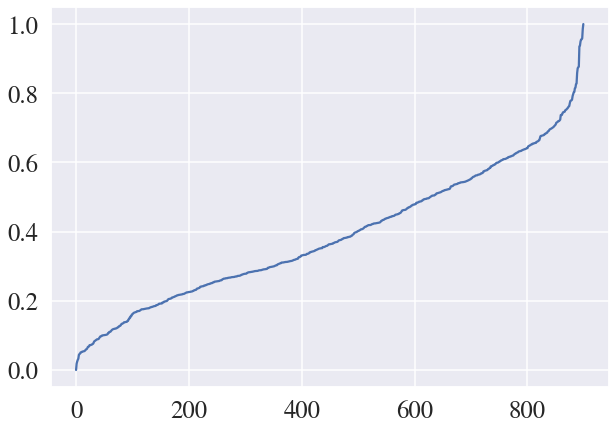

In [8]:
plt.plot(a)

In [9]:
B1 = euler_char(Data1[0],U,U,a)

100%|████████████████████████████████████████| 900/900 [00:11<00:00, 77.74it/s]


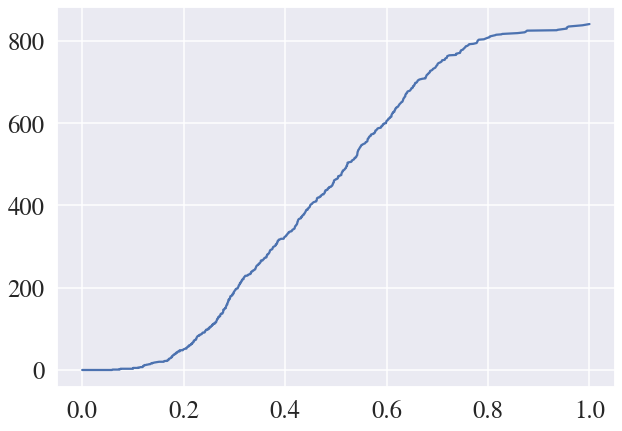

In [10]:
plt.plot(a,B1)



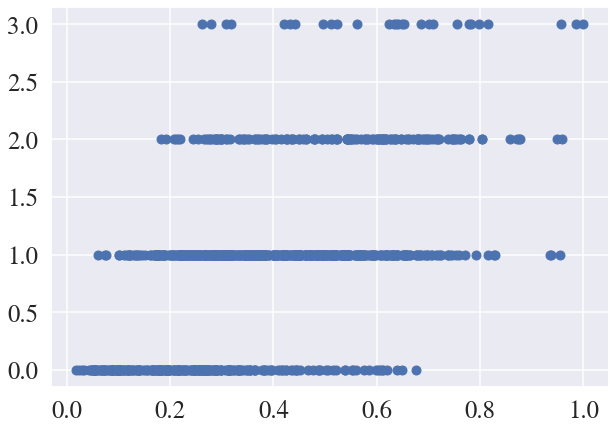

In [11]:
plt.plot(a[1::],np.diff(B1),'o')

In [12]:
a = np.unique(Data2[0])
len(a)

900

100%|████████████████████████████████████████| 900/900 [00:10<00:00, 88.10it/s]


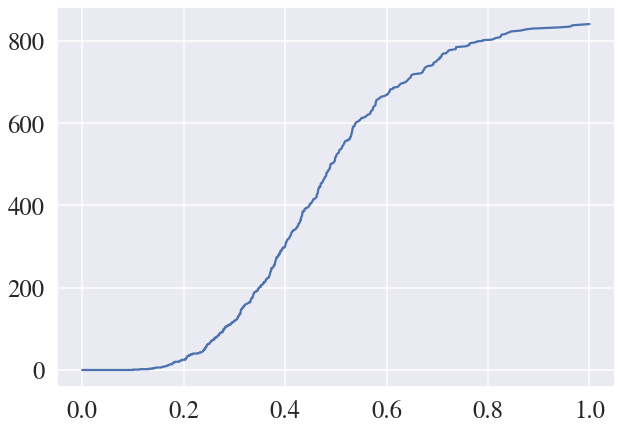

In [13]:
B1 = euler_char(Data2[0],U,U,a)
plt.plot(a,B1)


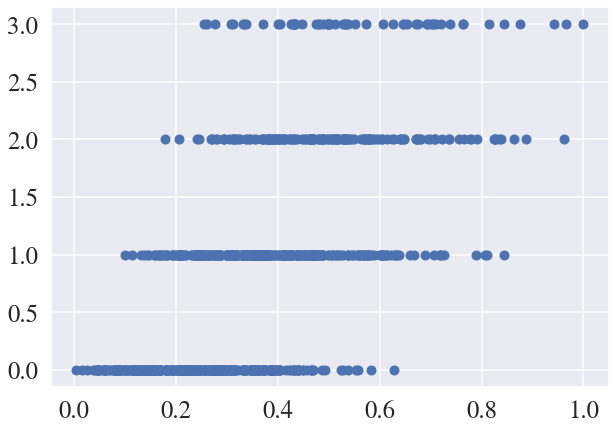

In [14]:
plt.plot(a[1::],np.diff(B1),'o')

In [15]:
A = np.random.rand(U,U)
# A = np.random.normal(.5,1,(U,U))
# A = (A - A.min())/(A.max() - A.min())
# A = np.random.permutation(Data1[0].flatten())
A = np.reshape(A,(30,30))
a = np.unique(A)
len(a)

900

100%|████████████████████████████████████████| 900/900 [00:10<00:00, 87.66it/s]


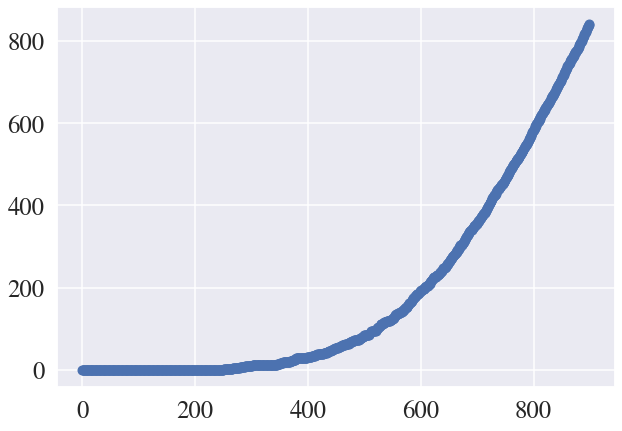

In [16]:
B1 = euler_char(A,U,U,a)
plt.plot(B1,'o')

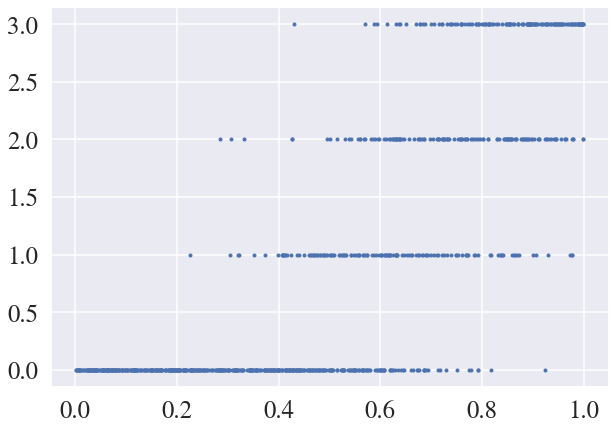

In [17]:
plt.plot(a[1::],np.diff(B1),'o',ms = 3)

In [18]:
Bdiff = np.diff(B1)
ps = []
for i in np.arange(0,900,100):
    p = [0,0,0,0]
    box = Bdiff[i:i+100]
    p[0] = np.sum((box == np.unique(Bdiff)[0])*1)/len(box)
    p[1] = np.sum((box == np.unique(Bdiff)[1])*1)/len(box)
    p[2] = np.sum((box == np.unique(Bdiff)[2])*1)/len(box)
    p[3] = np.sum((box == np.unique(Bdiff)[3])*1)/len(box)
    
    ps.append(p)

In [19]:
Bdiff = np.diff(B1)
ps = []
for i in np.arange(0,1,.1):
    p = [0,0,0,0]
    ai = a[1::]
    aind = np.where((ai<=i+.1) & (ai>=i))
    box = Bdiff[aind]
    p[0] = np.sum((box == np.unique(Bdiff)[0])*1)/len(box)
    p[1] = np.sum((box == np.unique(Bdiff)[1])*1)/len(box)
    p[2] = np.sum((box == np.unique(Bdiff)[2])*1)/len(box)
    p[3] = np.sum((box == np.unique(Bdiff)[3])*1)/len(box)
    
    ps.append(p)

In [20]:
ps = np.vstack(ps)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

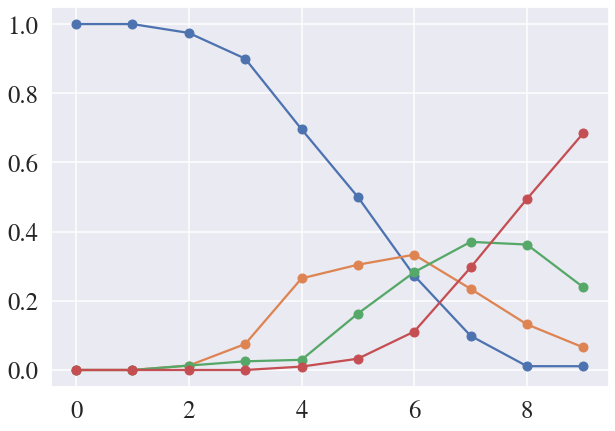

In [21]:
plt.plot(ps,'-o')

pstot = np.sum(ps,axis = 1)

pstot

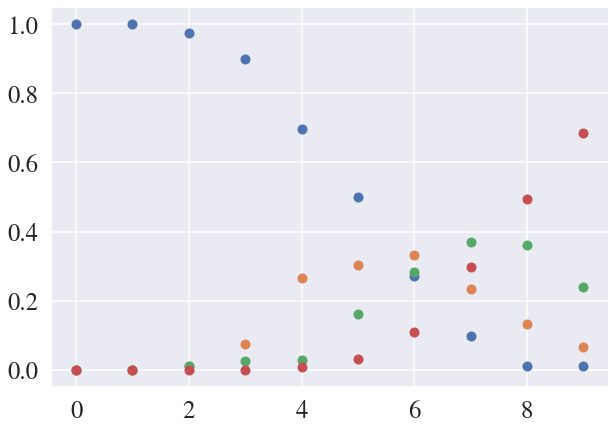

In [22]:
plt.plot(ps[:,0],'o')
plt.plot(ps[:,1],'o')
plt.plot(ps[:,2],'o')
plt.plot(ps[:,3],'o')

In [23]:
aind = np.where((a<=.1) & (a>=0))
aind

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98],
       dtype=int64),)

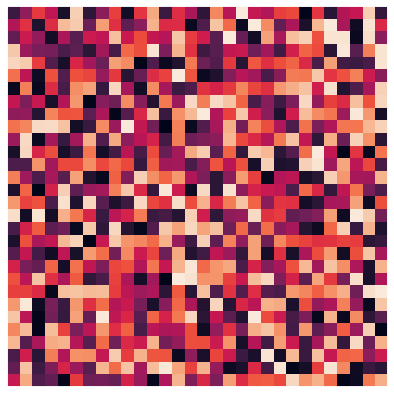

In [24]:
plt.imshow(A)

plt.gca().set(yticks=[])
plt.gca().set(xticks=[])

plt.savefig("random.eps")

Recreate Betti 1 Function from estimated distributions

In [25]:
Exps = np.zeros(90*10 + 1)
Exp2s = np.zeros(101)
Var = np.zeros(101)
count = 1

for i in range(10):
    for j in range(90):
        Exp = 0*ps[i,0] + 1*ps[i,1] + 2*ps[i,2] + 3*ps[i,3]
        Exps[count] = Exps[count-1] + Exp
        count += 1

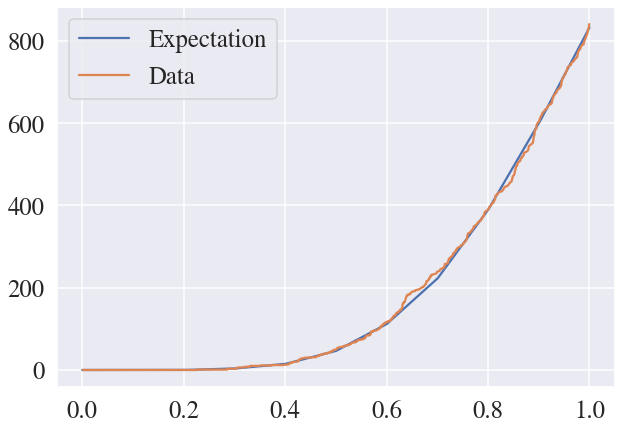

In [26]:
e = np.linspace(0,1,900)

# Exps = (Exps - Exps.min())/(Exps.max() - Exps.min())

B1 = np.vstack(B1)

# B1 = (B1 - B1.min())/(B1.max() - B1.min())

plt.plot(e,Exps[0:-1],label = "Expectation")

plt.plot(a,B1,label = "Data")


plt.legend()

In [ ]:
B1s = []
ayes = []
for i in range(100):
    A = np.random.rand(U,U)
    a = np.unique(A)
    B1 = euler_char(A,U,U,a)
    B1s.append(B1)
    ayes.append(a)

 79%|███████████████████████████████▋        | 712/900 [00:08<00:02, 84.21it/s]

In [ ]:
B1z = np.vstack(B1s)

In [ ]:
plt.close('all')

e = np.linspace(0,1,900)

B1zs = np.vstack(B1z).T

count = 0
for i in range(100):
    if count == 0:
        plt.plot(e,B1zs[:,i],'r',label = "Data")
    else:
        plt.plot(e,B1zs[:,i],'r')
    count += 1
        
sumB1zs = np.mean(B1zs,axis = 1)
varB1Zs = np.var(B1zs,axis = 1)

plt.plot(e,sumB1zs,label = "Expectation")

Bdiffall = np.diff(B1zs.T)

plt.ylabel(r"$\beta_1$")
plt.xlabel("$f(G)$")


plt.legend()

plt.savefig("randomdata.pdf")

In [ ]:
np.shape(B1zs[:,0])

In [ ]:
np.shape(Bdiffall)

In [ ]:
B = len(np.arange(0,1,.05))
allps = []
for k in range(100):
    Bdiff = Bdiffall[k,:]
    ps = []
    a = ayes[k]
    for i in np.arange(0,1,.05):
        p = [0,0,0,0]
        ai = a[1::]
        aind = np.where((ai<=i+.05) & (ai>=i))
        box = Bdiff[aind]
        p[0] = np.sum((box == np.unique(Bdiff)[0])*1)/len(box)
        p[1] = np.sum((box == np.unique(Bdiff)[1])*1)/len(box)
        p[2] = np.sum((box == np.unique(Bdiff)[2])*1)/len(box)
        p[3] = np.sum((box == np.unique(Bdiff)[3])*1)/len(box)

        ps.append(p)
    
    allps.append(ps)
        
        


In [ ]:
np.shape(allps)

In [ ]:

e = np.arange(0,1,.05)

allps = np.asarray(allps)

psum0 = np.zeros(B)
psum1 = np.zeros(B)
psum2 = np.zeros(B)
psum3 = np.zeros(B)

for i in range(B):
    psum0 = psum0 + allps[i,:,0]
    psum1 = psum1 + allps[i,:,1]
    psum2 = psum2 + allps[i,:,2]
    psum3 = psum3 + allps[i,:,3]

ps = np.vstack([psum0/B,psum1/B,psum2/B,psum3/B]).T

plt.plot(e,ps,'-o')

plt.ylabel("Probability")
plt.xlabel("$f(G)$")

plt.legend([r'$P(\Delta \beta_1 = 0)$',r'$P(\Delta \beta_1 = 1)$',r'$P(\Delta \beta_1 = 2)$',r'$P(\Delta \beta_1 = 3)$'])

plt.savefig("discprob.pdf")

In [ ]:
Exps = np.zeros(90*10 + 1)
Exp2s = np.zeros(101)
Var = np.zeros(101)
count = 1

for i in range(B):
    for j in range(45):
        Exp = 0*ps[i,0] + 1*ps[i,1] + 2*ps[i,2] + 3*ps[i,3]
        Exps[count] = Exps[count-1] + Exp
        count += 1

In [ ]:
e = np.linspace(0,1,900)

plt.plot(e,sumB1zs,'o',label = "Empirical Expectation")
plt.plot(e,Exps[0:-1],linewidth = 5,label = "Modeled Expectation")

# plt.plot(e,sumB1zs - varB1Zs,'o',label = "Empirical Expectation")
# plt.plot(e,sumB1zs + varB1Zs,'o',label = "Empirical Expectation")
plt.ylabel(r"$\beta_1$")
plt.xlabel("$f(G)$")

plt.legend()

plt.savefig("empvsmodel.pdf")